In [36]:
import pandas as pd
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [37]:

# 데이터 불러오기
train_df = pd.read_csv('./train_d.csv')
test_df = pd.read_csv('./test_d.csv')
building_info = pd.read_csv('./data/building_info.csv')
bscaleinfo = pd.read_csv('./b_scale_m_info.csv')

In [38]:


def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / np.maximum(denominator, 1e-8)
    return np.mean(diff) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

In [39]:
train_df.columns

Index(['건물번호', '일시', '기온', '강수량', '풍속', '습도', '전력소비량', 'datetime', 'day',
       'is_weekend', 'month', '태양광용량', 'ESS저장용량', 'PCS용량', '연면적_log',
       '냉방면적_log', 'weight', '태양광용량_exists', 'ESS저장용량_exists', 'PCS용량_exists',
       '불쾌지수', '체감온도', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'lag_1',
       'lag_24', 'lag_168', 'roll_m_6', 'roll_m_24', 'roll_s_24', '건물유형_건물기타',
       '건물유형_공공', '건물유형_백화점', '건물유형_병원', '건물유형_상용', '건물유형_아파트', '건물유형_연구소',
       '건물유형_학교', '건물유형_호텔'],
      dtype='object')

In [40]:
test_df.columns

Index(['건물번호', '일시', '기온', '강수량', '풍속', '습도', 'datetime', 'day', 'is_weekend',
       'month', '태양광용량', 'ESS저장용량', 'PCS용량', '연면적_log', '냉방면적_log',
       '태양광용량_exists', 'ESS저장용량_exists', 'PCS용량_exists', '불쾌지수', '체감온도',
       'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'lag_1', 'lag_24',
       'lag_168', 'roll_m_6', 'roll_m_24', 'roll_s_24', '건물유형_건물기타', '건물유형_공공',
       '건물유형_백화점', '건물유형_병원', '건물유형_상용', '건물유형_아파트', '건물유형_연구소', '건물유형_학교',
       '건물유형_호텔'],
      dtype='object')

In [6]:
train_list = []
val_list   = []

for b_id, df_b in train_df.groupby("건물번호"):
    df_b = df_b.sort_values("datetime").reset_index(drop=True)

    split_idx = int(len(df_b) * 0.8)   # 8:2 분할

    train_list.append(df_b.iloc[:split_idx])
    val_list.append(df_b.iloc[split_idx:])

rf_train_df = pd.concat(train_list).reset_index(drop=True)
rf_val_df   = pd.concat(val_list).reset_index(drop=True)

print(rf_train_df.shape, rf_val_df.shape)

(163200, 41) (40800, 41)


In [41]:
time_weather = [
    "기온", "강수량", "풍속", "습도",
    "불쾌지수", "체감온도",
    "hour_sin", "hour_cos",
    "week_sin", "week_cos",
    "day", "is_weekend", "month"
]

building_info = [
    "연면적_log", "냉방면적_log",
    "태양광용량", "ESS저장용량", "PCS용량",
    "태양광용량_exists", "ESS저장용량_exists", "PCS용량_exists"
]

building_type = [
    c for c in train_df.columns if c.startswith("건물유형_")
]


feature_cols = time_weather + building_info + building_type



In [43]:
from sklearn.ensemble import RandomForestRegressor

X = train_df[feature_cols]
y = train_df["전력소비량"]        # 원 단위
w = train_df["weight"]            # 1.0 or <1.0

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X, y, sample_weight=w)


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [14]:


X_train = rf_train_df[feature_cols]
y_train = rf_train_df["전력소비량"]
w_train = rf_train_df.get("weight", None)

X_val = rf_val_df[feature_cols]
y_val = rf_val_df["전력소비량"]

In [15]:
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [None, 20, 30],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", 0.7]
}

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

rand = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=15,
    scoring=smape_scorer,
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

X = rf_train_df[feature_cols]
y = rf_train_df["전력소비량"]        # 원 단위
w = rf_train_df.get("weight", None)

rand.fit(X, y, sample_weight=w)


print("Best SMAPE:", -rand.best_score_)
print("Best params:", rand.best_params_)

best_rf = rand.best_estimator_


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best SMAPE: 43.450032021325235
Best params: {'n_estimators': 500, 'min_samples_leaf': 3, 'max_features': 0.7, 'max_depth': 20}


In [17]:
y_val_pred = best_rf.predict(X_val)
val_smape = smape(y_val.values, y_val_pred)

print(f"Best RF Validation SMAPE (recheck): {val_smape:.4f}")


Best RF Validation SMAPE (recheck): 16.2917


In [18]:
cv_results = pd.DataFrame(rand.cv_results_)

summary_cols = [
    "rank_test_score",
    "mean_test_score",
    "std_test_score",
    "param_n_estimators",
    "param_max_depth",
    "param_min_samples_leaf",
    "param_max_features"
]

rf_tuning_summary = cv_results[summary_cols].copy()

rf_tuning_summary["SMAPE"] = -rf_tuning_summary["mean_test_score"]
rf_tuning_summary["SMAPE_std"] = rf_tuning_summary["std_test_score"]

rf_tuning_summary = rf_tuning_summary.rename(columns={
    "param_n_estimators": "n_estimators",
    "param_max_depth": "max_depth",
    "param_min_samples_leaf": "min_samples_leaf",
    "param_max_features": "max_features"
})

rf_tuning_summary = rf_tuning_summary.sort_values("SMAPE").reset_index(drop=True)


In [19]:
rf_tuning_summary.head(10)


,rank_test_score,mean_test_score,std_test_score,n_estimators,max_depth,min_samples_leaf,max_features,SMAPE,SMAPE_std
0,1,-43.450032,0.994260,500,20,3,0.7,43.450032,0.994260
1,2,-43.523065,0.942476,500,30,1,0.7,43.523065,0.942476
2,3,-43.526870,0.938859,500,None,3,0.7,43.526870,0.938859
3,4,-43.532032,0.912686,300,30,1,0.7,43.532032,0.912686
4,5,-43.533784,0.918851,300,None,3,0.7,43.533784,0.918851
5,6,-43.572341,1.025561,500,30,5,0.7,43.572341,1.025561
6,7,-43.604364,0.966896,300,30,5,0.7,43.604364,0.966896
7,8,-43.803884,1.572107,300,None,1,sqrt,43.803884,1.572107
8,9,-43.854052,1.407859,500,20,1,sqrt,43.854052,1.407859
9,10,-43.896113,1.538824,300,30,3,sqrt,43.896113,1.538824


In [21]:
x_test = test_df[feature_cols]

In [44]:
predictions = rf.predict(x_test)
submission = pd.DataFrame(predictions)

In [22]:
predictions = best_rf.predict(x_test)
submission = pd.DataFrame(predictions)

In [45]:
submission.head()

,0
0,0.442710
1,0.385772
2,0.312534
3,0.293881
4,0.285503


In [46]:
scale_dict = {int(r["건물번호"]): (r["min"], r["max"]) for _, r in bscaleinfo.iterrows()}

In [47]:
sub = pd.read_csv('./data/sample_submission.csv')

In [48]:
sub

,num_date_time,answer
0,1_20240825 00,0
1,1_20240825 01,0
2,1_20240825 02,0
3,1_20240825 03,0
4,1_20240825 04,0
...,...,...
16795,100_20240831 19,0
16796,100_20240831 20,0
16797,100_20240831 21,0
16798,100_20240831 22,0


In [49]:
sub['answer'] = submission

In [50]:
sub

,num_date_time,answer
0,1_20240825 00,0.442710
1,1_20240825 01,0.385772
2,1_20240825 02,0.312534
3,1_20240825 03,0.293881
4,1_20240825 04,0.285503
...,...,...
16795,100_20240831 19,0.354107
16796,100_20240831 20,0.498310
16797,100_20240831 21,0.467200
16798,100_20240831 22,0.552685


In [51]:

df = sub.copy()

df[["building", "date_hour"]] = df["num_date_time"].str.split("_", expand=True)
df[["date", "hour"]] = df["date_hour"].str.split(" ", expand=True)
df = df.drop(columns=["date_hour"])

df["building"] = df["building"].astype(int)
df["datetime"] = pd.to_datetime(df["date"] + " " + df["hour"] + ":00")

In [52]:

def inverse_scale(value, b_id):
    y_min, y_max = scale_dict[b_id]
    return value * (y_max - y_min) + y_min

df["answer"] = [
    inverse_scale(v, b)
    for v, b in zip(df["answer"], df["building"])
]



In [53]:
df

,num_date_time,answer,building,date,hour,datetime
0,1_20240825 00,4788.771686,1,20240825,00,2024-08-25 00:00:00
1,1_20240825 01,4453.714302,1,20240825,01,2024-08-25 01:00:00
2,1_20240825 02,4022.734949,1,20240825,02,2024-08-25 02:00:00
3,1_20240825 03,3912.972491,1,20240825,03,2024-08-25 03:00:00
4,1_20240825 04,3863.666931,1,20240825,04,2024-08-25 04:00:00
...,...,...,...,...,...,...
16795,100_20240831 19,1733.952800,100,20240831,19,2024-08-31 19:00:00
16796,100_20240831 20,2101.808584,100,20240831,20,2024-08-31 20:00:00
16797,100_20240831 21,2022.448478,100,20240831,21,2024-08-31 21:00:00
16798,100_20240831 22,2240.517948,100,20240831,22,2024-08-31 22:00:00


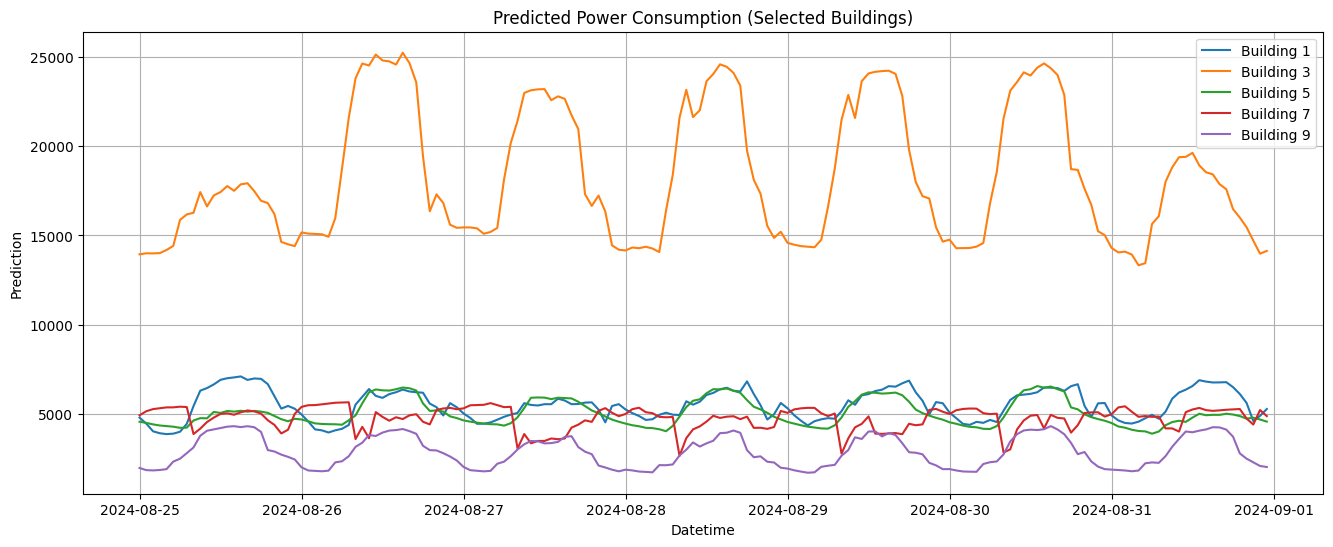

In [54]:
import matplotlib.pyplot as plt

selected_buildings = [1, 3, 5, 7, 9]

plt.figure(figsize=(16, 6))

for b in selected_buildings:
    temp = df[df["building"] == b]
    plt.plot(temp["datetime"], temp["answer"], label=f"Building {b}")

plt.title("Predicted Power Consumption (Selected Buildings)")
plt.xlabel("Datetime")
plt.ylabel("Prediction")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
sub['answer'] = df['answer']

In [56]:
sub

,num_date_time,answer
0,1_20240825 00,4788.771686
1,1_20240825 01,4453.714302
2,1_20240825 02,4022.734949
3,1_20240825 03,3912.972491
4,1_20240825 04,3863.666931
...,...,...
16795,100_20240831 19,1733.952800
16796,100_20240831 20,2101.808584
16797,100_20240831 21,2022.448478
16798,100_20240831 22,2240.517948


In [57]:
sub.to_csv('./sub_RF_jhpara.csv', index=False)